# HOMEWORK 7

In this homework you are going to rectify a document image that suffers from severe distortion. You will be using the same image and the same detected corners from the previous lesson (lesson 6).

Remember, OpenCV documentation is your friend ;-)

At the end of this notebook, there are a couple of questions for you to answer.

In [13]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image we will be working on in this homework.

Rows: 403, Cols: 302


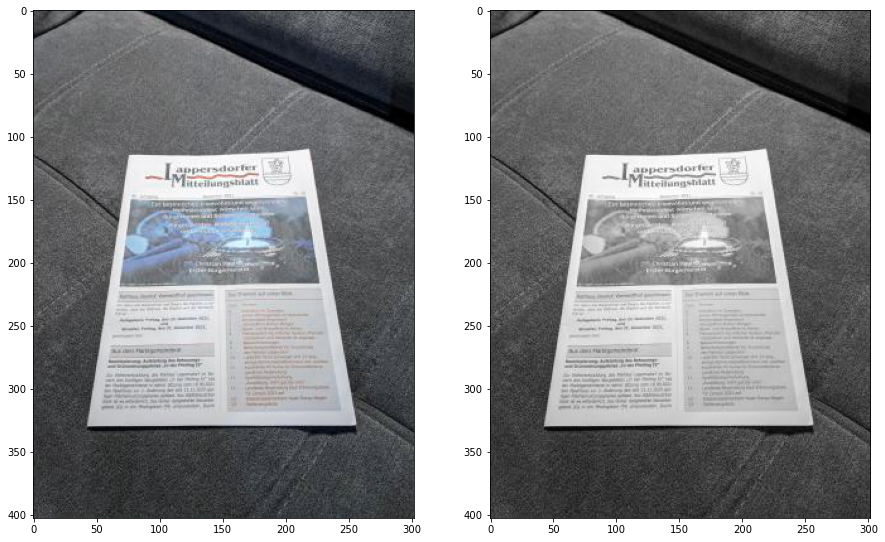

In [14]:
img = cv2.imread('imgs/document.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)/255
rows, cols = gray.shape

# Let's plot the image
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')
print(f'Rows: {rows}, Cols: {cols}')

In the previous homework you should have detected the four document corners and you will need to use them here. But don't worry if the previous homework did not work out for you, I am going to provide you with the corners coordinates here :-)

In [15]:
top_left = [76, 115]
top_right = [219, 111]
bottom_left = [43, 330]
bottom_right = [256, 329]

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x27aaa5e70d0>)

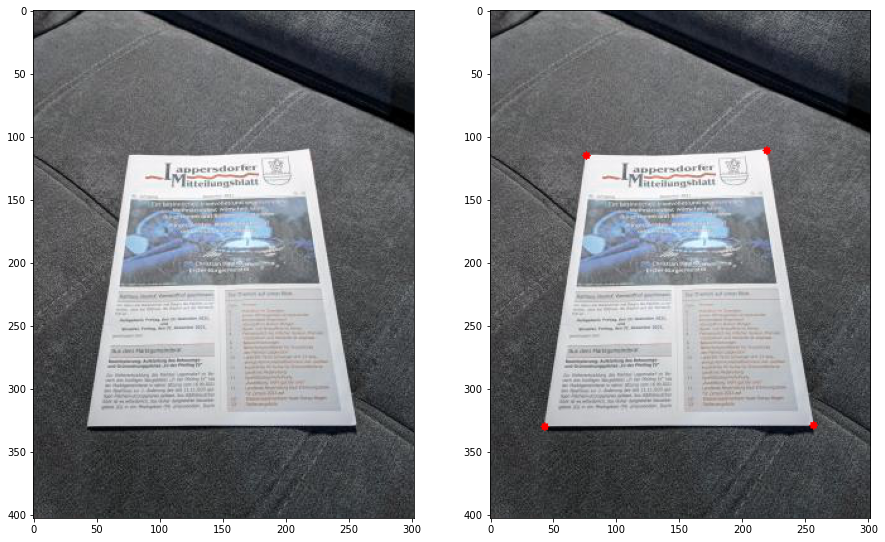

In [16]:
# Let's plot the points
out = np.copy(img)
out = cv2.circle(out, tuple(top_left), 3, (255,0,0), -1)
out = cv2.circle(out, tuple(top_right), 3, (255,0,0), -1)
out = cv2.circle(out, tuple(bottom_left), 3, (255,0,0), -1)
out = cv2.circle(out, tuple(bottom_right), 3, (255,0,0), -1)

plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(out)

### Document Rectification

Let's now try to rectify the document. The goal is to bring the four document corners to the image corners. For instance, we want the top-left document corner to become (0, 0), i.e., the top-left corner of the image itself. In that way, we will fill the complete image with document information and we will throw away parts of the images that correspond to background (which are of no use to us).

In [17]:
# Define the matrix of source points corresponding to the 4 document corners.
# The matrix shall have shape (4, 2), i.e., 4 corners x 2 coordinates
# Note: You will need to explicitly use float32 data type
src = np.array([top_left, top_right, bottom_left, bottom_right], dtype=np.float32)

# Define the matrix of target (destination) points corresponding to the 4 image corners.
# The matrix shall have shape (4, 2), i.e., 4 corners x 2 coordinates
# Note: You will need to explicitly use float32 data type
# Note2: The order of points in src and dst must be the same
dst = np.array([[0, 0], [cols-1, 0], [0, rows-1], [cols-1, rows-1]], dtype=np.float32)

Let's first start with the affine transform for document rectification. The affine transform can be analytically calculated using 3 point pairs. Therefore, let's select the **first 3 points** and calculate the correspnding transfrom. We will then use the transform to rectify the document.

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x27aaa291520>)

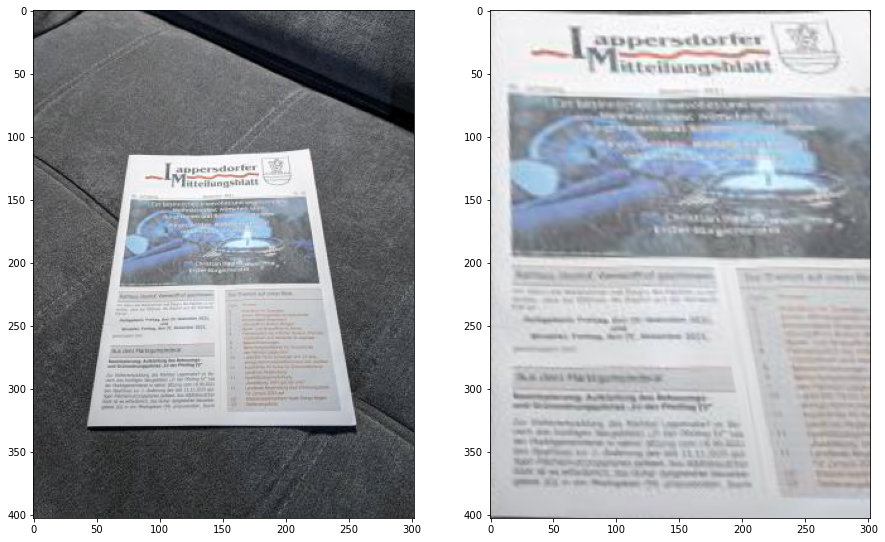

In [18]:
# Compute the affine transform matrix (you'll have to use getAffineTransform function from OpenCV here)
# Use the first 3 points from your src and dst matrix
M = cv2.getAffineTransform(src[:3], dst[:3])

# Build the rectified image using the computed matrix (you'll have to use warpAffine function from OpenCV here)
rectified = cv2.warpAffine(img, M, (cols, rows))

# Let's plot the results
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(rectified)

Well, this is not bad by certainly not what we were aiming for. Let's try the **last 3** points instead.

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x27aaa58c550>)

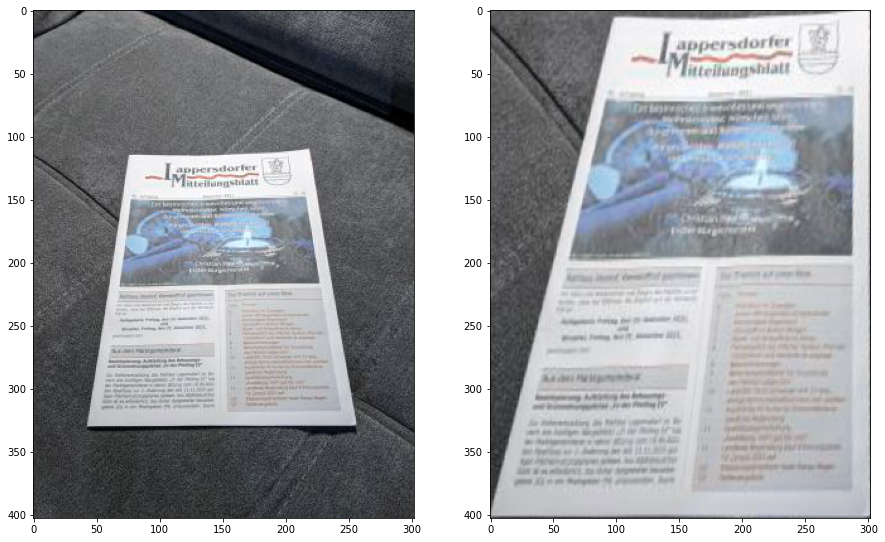

In [19]:
# Compute the affine transform matrix (use getAffineTransform)
# Use the last 3 points from your src and dst matrix
M = cv2.getAffineTransform(src[-3:], dst[-3:])

# Build the rectified image using the computed matrix (use warpAffine)
rectified = cv2.warpAffine(img, M,(cols, rows))

# Let's plot the results
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(rectified)

The result looks different but not better. This approach doesn't seem to be helping then. Let's use **all 4 points** and let OpenCV **estimate** (remember that 4 points are too many for an analytical solution) the best fitting affine transform for us. It'll internally apply optimization approaches as well as RANSAC.

[[1]
 [1]
 [0]
 [1]]


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x27aa9c66520>)

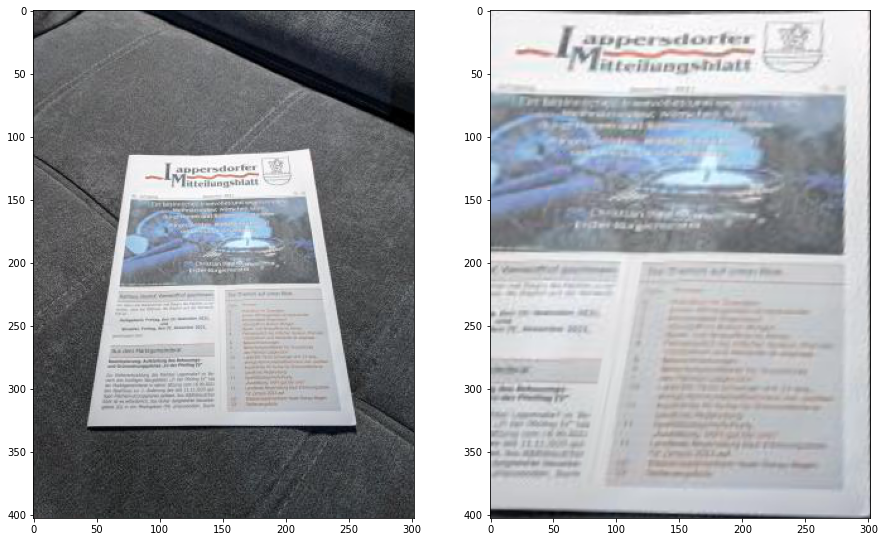

In [20]:
# Estimate the optimal affine transform matrix (you'll have to use estimateAffine2D function from OpenCV here)
# estimateAffine2D it returns the best fitting affine matrix as well as the vector of inliers (1 -> inlier,
# 0 -> outlier).

to_arr = np.zeros_like(img)
M, inliers = cv2.estimateAffine2D(src, dst)
print(inliers)

# Build the rectified image using the computed matrix (use warpAffine)
rectified = cv2.warpAffine(img, M, (cols, rows))

# Let's plot the results
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(rectified)

There is not much of an improvement either. Let's try homography instead of affine transform. Remember that for computing the homography analytically we need to use 4 pairs of points.

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x27aaa819790>)

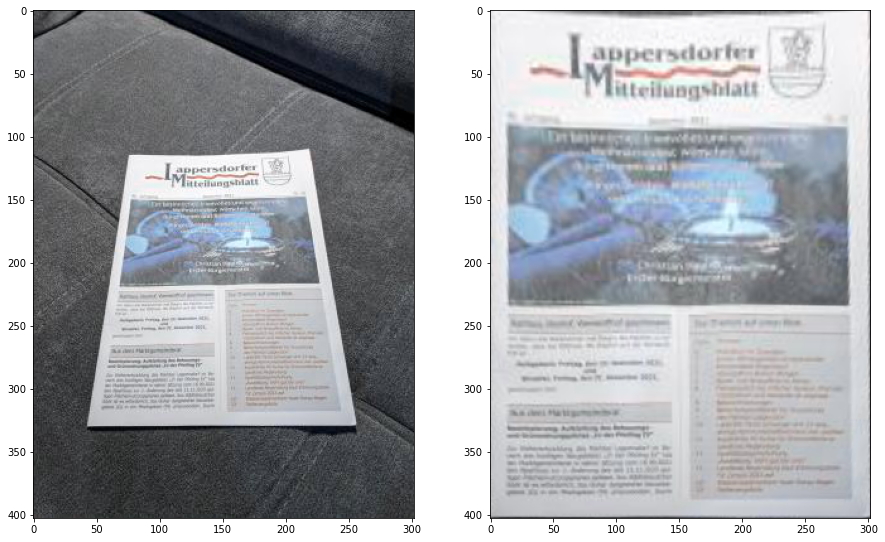

In [21]:
# Compute the homography matrix (you'll have to use getPerspectiveTransform function from OpenCV here)
M = cv2.getPerspectiveTransform(src, dst)

# Build the rectified image using the computed matrix (you'll have to use warpPerspective function from OpenCV)
rectified = cv2.warpPerspective(img, M, (cols, rows))
# print(M)

# Let's plot the results
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(rectified)

### Questions
* The affine transform does not seem to be working well in this case. Why?
* What can you tell me about the values you have obtained for the inliers vector? What does it mean?
* How does the result from homography look? Does it work well enough? 

Remember, I am **not** looking for a particular answer. I want to see how you think, so be creative ;-)

### Answers
* Affine transformation saves parallel lines. In our case, we have a projection of the original document and so we need an appropriate transformation to get the document back to its original shape.
* "Inliers" is a matrix of "indicators" about every point in the src matrix. 1 - this means this point is visible on the transformed (resulting) picture canvas - "inlier". 0 - the point is outside of the transformed picture canvas, a non-visible "outlier".
* It looks good enough. Guess it is nearly the best we can get from the source picture.